In [1]:
from bs4 import BeautifulSoup
import requests
import tarfile
import re
import sys
import os
import pandas as pd 
import xml.etree.ElementTree as et
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

In [2]:
url = 'https://echanges.dila.gouv.fr/OPENDATA/BODACC/2020/'
r = requests.get(url, allow_redirects=True)
soup = BeautifulSoup(r.content, "lxml")
files = []

In [3]:
pages = soup.findAll('a', href=re.compile('RCS-A')) #regex to target only RCS-A files (bodacc A)
print("Total Links Found:",pages.__len__())
for l in pages:
     files.append(l.get('href'))

Total Links Found: 197


In [4]:
test = 'RCS-A_BXA20200102.taz'
url2 = f"https://echanges.dila.gouv.fr/OPENDATA/BODACC/2020/{test}"
response = requests.get(url2, stream=True)
if response.status_code == 200:
    with open(test, 'wb') as f:
        f.write(response.raw.read())

In [5]:
def extract_tar():
    '''Extract .tar files to .xml'''
    tar = tarfile.open(test)
    tar.extractall()
    tar.close()
extract_tar()

In [6]:
def get_personnes(root):
    '''get personnes in avis '''
    for personnes in root.iter("personnes"):
        for personne in personnes.iter('personne'):
            #hommage à camacho
            try:
                choix = personne.find('personnePhysique/numeroImmatriculation/numeroIdentification')
                s_numero_identification.append((choix.text).replace(' ', ''))
            except:

                try:
                        choix2 = personne.find('personneMorale/numeroImmatriculation/numeroIdentification')
                        s_numero_identification.append((choix2.text).replace(' ', ''))

                except:
                    print('Non immatriculée')
                    s_numero_identification.append(None)                                            
                                        
def get_adresse_france(root):
    '''get adresses in personnes '''
    for personnes in root.iter("personnes"):
        for personne in personnes.iter('personne'):
            try:
                cp = personne.find('adresse/france/codePostal')
                s_cp_personne.append(cp.text)
            except:
                s_cp_personne.append(None) #should append(s_cp from /get_etablissement)

            try:
                ville = personne.find('adresse/france/ville')
                s_ville_personne.append(ville.text)#should append(s_cp from /get_etablissement)

            except:
                
                s_ville_personne.append(None)

In [7]:
s_numero_identification = []
s_cp_personne = []
s_ville_personne = []
s_date_parution = []
s_numeroDepartement=[]

tree=et.parse('RCS-A_BXA20200102.xml')
root=tree.getroot()

for i in root.iter("avis"):
    root1 = i 
    
    x = 'MIXTE'
    d = "D'"
    
    
    get_personnes(root1)
    get_adresse_france(root1)
    #get_adresse_france(root1) not called
    
    
    # 'tribunal' = "GREFFE DU TRIBUNAL MIXTE DE COMMERCE DE "CITY" " or "GREFFE DU TRIBUNAL DE COMMERCE DE "CITY"
    # str that must be erased to get CITY only
    n_dep = root1.find('tribunal')
    if x in n_dep.text:
        s_numeroDepartement.append((n_dep.text).replace('GREFFE DU TRIBUNAL MIXTE DE COMMERCE DE ', ''))     
    elif d in n_dep.text:
        s_numeroDepartement.append((n_dep.text).replace("GREFFE DU TRIBUNAL DE COMMERCE D'", ''))  
    else:
        s_numeroDepartement.append((n_dep.text).replace("GREFFE DU TRIBUNAL DE COMMERCE DE ", ''))  
    
    
    g = root.find('dateParution')
    s_date_parution.append(g.text)        


Non immatriculée
Non immatriculée


In [8]:

# test lines number
# line number must be all the same len 
# line number = len(s_numeroDepartement))

df1 = pd.DataFrame({
         'numero d identification': len(s_numero_identification),
         #'s_cp_personne' : len(s_cp_personne), 
         #'s_ville_personne': len(s_ville_personne),
         'tribunal':len(s_numeroDepartement),
         'date_parution': len(s_date_parution) 
        
},index=["nb_lignes"]).T


df1

,nb_lignes
numero d identification,1246
tribunal,1246
date_parution,1246


In [9]:
liste_test = [
s_numero_identification,
s_numeroDepartement,
s_date_parution
]

In [10]:
df_final = pd.DataFrame({
             'Num RCS': s_numero_identification,
             'tribunal': s_numeroDepartement,
             #'CP': s_cp_personne,
                         
             #'ville':s_ville_personne, 
             'date de creation':s_date_parution
             
            })

In [11]:
df_final

,Num RCS,tribunal,date de creation
0,850828005,BOURG-EN-BRESSE,2020-05-28
1,883520611,ST-QUENTIN,2020-05-28
2,883499675,ST-QUENTIN,2020-05-28
3,883513517,ST-QUENTIN,2020-05-28
4,883526733,ST-QUENTIN,2020-05-28
...,...,...,...
1241,883274870,CAYENNE,2020-05-28
1242,883502429,SAINT-PIERRE,2020-05-28
1243,883521973,SAINT-PIERRE,2020-05-28
1244,883502585,SAINT-PIERRE,2020-05-28


In [12]:
pd.to_numeric(df_final['Num RCS'], downcast='integer')

0       850828005.0
1       883520611.0
2       883499675.0
3       883513517.0
4       883526733.0
           ...     
1241    883274870.0
1242    883502429.0
1243    883521973.0
1244    883502585.0
1245    847948569.0
Name: Num RCS, Length: 1246, dtype: float64

In [13]:
df_final

,Num RCS,tribunal,date de creation
0,850828005,BOURG-EN-BRESSE,2020-05-28
1,883520611,ST-QUENTIN,2020-05-28
2,883499675,ST-QUENTIN,2020-05-28
3,883513517,ST-QUENTIN,2020-05-28
4,883526733,ST-QUENTIN,2020-05-28
...,...,...,...
1241,883274870,CAYENNE,2020-05-28
1242,883502429,SAINT-PIERRE,2020-05-28
1243,883521973,SAINT-PIERRE,2020-05-28
1244,883502585,SAINT-PIERRE,2020-05-28


In [14]:
df_final['date de creation'] =  pd.to_datetime(df_final['date de creation'])

In [15]:
df_final['day'] = pd.DatetimeIndex(df_final['date de creation']).day
df_final['month'] = pd.DatetimeIndex(df_final['date de creation']).month
df_final['year'] = pd.DatetimeIndex(df_final['date de creation']).year
df_final['quarter'] = pd.DatetimeIndex(df_final['date de creation']).quarter


In [16]:
df_final

,Num RCS,tribunal,date de creation,day,month,year,quarter
0,850828005,BOURG-EN-BRESSE,2020-05-28,28,5,2020,2
1,883520611,ST-QUENTIN,2020-05-28,28,5,2020,2
2,883499675,ST-QUENTIN,2020-05-28,28,5,2020,2
3,883513517,ST-QUENTIN,2020-05-28,28,5,2020,2
4,883526733,ST-QUENTIN,2020-05-28,28,5,2020,2
...,...,...,...,...,...,...,...
1241,883274870,CAYENNE,2020-05-28,28,5,2020,2
1242,883502429,SAINT-PIERRE,2020-05-28,28,5,2020,2
1243,883521973,SAINT-PIERRE,2020-05-28,28,5,2020,2
1244,883502585,SAINT-PIERRE,2020-05-28,28,5,2020,2


In [17]:
df_prep = df_final[['Num RCS','tribunal']]
df_prep

,Num RCS,tribunal
0,850828005,BOURG-EN-BRESSE
1,883520611,ST-QUENTIN
2,883499675,ST-QUENTIN
3,883513517,ST-QUENTIN
4,883526733,ST-QUENTIN
...,...,...
1241,883274870,CAYENNE
1242,883502429,SAINT-PIERRE
1243,883521973,SAINT-PIERRE
1244,883502585,SAINT-PIERRE


In [18]:
df_final.to_json(path_or_buf = 'test.json',
    orient='index')

In [19]:
df_count = df_prep.groupby(by="tribunal").count().sort_values(by = 'Num RCS', ascending = False).head(10)
df_count

,Num RCS
tribunal,
PARIS,115
MONTPELLIER,76
AGEN,60
MT-DE-MARSAN,46
TOULOUSE,43
RODEZ,39
NANTERRE,36
BOBIGNY,35
BORDEAUX,35


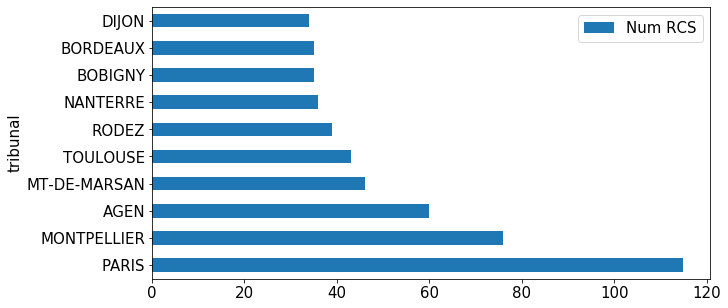

In [20]:
df_count.plot.barh(figsize=(10, 5))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class